# Inversion of Time Domain Electromagnetic (TDEM) Sounding Data

In this notebook you will use a forward model for the TDEM response of a layered half space to invert TDEM data. The first part of the notebook will walk you through inversion of a synthetic dataset, then in the second part you will set up an inversion of a real dataset from [Sit' Tlein (Malaspina Glacier)](https://esrs.jsc.nasa.gov/Collections/EarthFromSpace/lores.pl?PHOTO=STS028-97-81) in southern Alaska.  

More assignment-related info?

# Part 0 - Information about model

Layered half space analytical solution  
Requires wavefom info 

# Part 1 - Synthetic example

To begin we will generate a synthetic dataset with a forward model, add some noise, and then try to invert to recover the starting earth model. You won't need to do any programming in this part - the goal is just to familiarize you with the tools in this notebook so that you can use them to invert the real dataset later in the notebook.

In [1]:
import sys
import os
sys.path.insert(0, os.getcwd())

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import matplotlib

import walktem

## Generate synthetic data

First we will load a real data file to grab some parameters necessary for the forward model. Note that this is not strictly necessary, but it is quicker to do than making them up.

In [2]:
# Load TDEM info
data = pd.read_csv("./geo4_tdem.txt", header=1)
t_obs = data["t"].to_numpy()

waveform = pd.read_csv("./tdem_waveform.txt", header=1)
waveform = {"t": waveform["t"].to_numpy(), "i": waveform["i"].to_numpy()}
loopsize = 40.0

Next we make up some stratigraphy - in this case a three layered earth - and use a utiliy function we've provided to visualize the strat column. Our synthetic stratigraphy will be a conductive layer sandwiched between two resistive ones. There are many scenarios where this type of electro-stratigraphy might come up, for example an aquifer, or a sulfide mineral deposit.

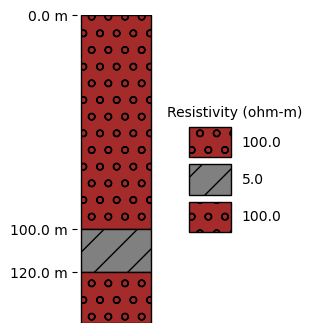

In [3]:
layer_thicknesses = [100, 20] # Two thicknesses (bottom layer is assumed infinite)
layer_resistivities = [100, 5, 100]
walktem.strat_plot(layer_thicknesses, layer_resistivities, hatches=["o", "/"], colors=["brown", "grey"])

Then we will use a forward model for the response of a TDEM instrument over a layered earth to generate a synthetic TDEM dataset.

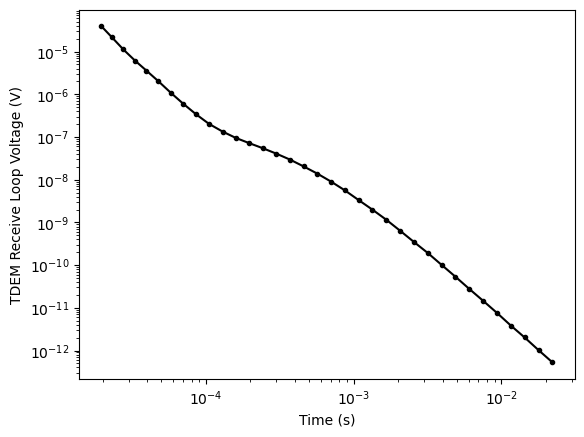

In [4]:
# Forward model
synth = walktem.walktem(layer_resistivities, np.cumsum(layer_thicknesses), t_obs, waveform, loopsize)

# Add noise
synth += np.random.normal(loc=0, scale=synth*.01, size=len(synth))

# Make plot
plt.loglog(t_obs, synth, "k.-")
plt.xlabel("Time (s)")
plt.ylabel("TDEM Receive Loop Voltage (V)")
plt.show()

## Invert synthetic data

First we need to define what a good fit to the synthetic data is. We will choose the L2 norm, $||data-model||^2_2$, scaled by the data value. The function `misfit_nlyr` implements this. We will need to pick a starting set of parameters for the inversion, `x0`. This is a very important input - just as important as the choice of misfit function. Choosing a bad initial `x0` can make it impossible for your optimizer to find a good-fitting solution. For this synthetic example we know the correct solution, but with real data you never do and must often use other knowledge to come up with a good `x0` I'll choose something that generally represents the electro-stratigraphy (resistive, conductive, resistive) but is notable different from what we know to be the true model.

In [2]:
def misfit_nlyr(x, data, t_obs, waveform, loopsize):
    # Split x into resistivity and thickness
    nlyr = (len(x)+1)//2
    layer_resistivities = x[:nlyr]
    layer_thicknesses = x[nlyr:]
    model = walktem.walktem(layer_resistivities, np.cumsum(layer_thicknesses), t_obs, waveform, loopsize)
    return np.sum(np.power(data-model, 2)/((.1*data)**2))

init_layer_resistivities = [150, 10]
init_layer_thicknesses = [50]

x0 = init_layer_resistivities + init_layer_thicknesses

# We also need to provide parameter bounds for the inversion, here I am constraining the resistivity to betweel 1 and 500 ohm meters
# and the layer thickness to between 0.5 and 200 meters
bounds = [(1, 500)]*2 + [(0.5, 200)]*1

# Forward model
x0_model = walktem.walktem(x0[:(len(x0)+1)//2], np.cumsum(x0[(len(x0)+1)//2:]), t_obs, waveform, loopsize)

# Make plot
plt.loglog(t_obs, synth, "k.-", label="Synthetic Data")
plt.loglog(t_obs, x0_model, "r.-", label="Initial Guess")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("TDEM Receive Loop Voltage (V)")
plt.show()

NameError: name 'walktem' is not defined

We start to replicate the shape of the observed decay curve, but are still quite different! Now we can run a minimization algorithm to seek an earth model that better matches the observed data. The function call below implements this. See this page for information about all of the arguments. Optimization (a.k.a. minimization) is a complex topic, worthy of class(es) in its own right. The next cell will take several tens of seconds to run.

In [9]:
# Run optimizer
res = scipy.optimize.minimize(
    misfit_nlyr,
    x0,
    method="nelder-mead",
    args=(synth, t_obs, waveform, loopsize),
    bounds=bounds,
    options={"fatol": 1e-10, "maxfev": len(x0) * 300},
)

print(res)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 404.6970010582223
             x: [ 1.072e+02  4.280e+01  6.493e+01]
           nit: 133
          nfev: 249
 final_simplex: (array([[ 1.072e+02,  4.280e+01,  6.493e+01],
                       [ 1.072e+02,  4.280e+01,  6.493e+01],
                       [ 1.072e+02,  4.280e+01,  6.493e+01],
                       [ 1.072e+02,  4.280e+01,  6.493e+01]]), array([ 4.047e+02,  4.047e+02,  4.047e+02,  4.047e+02]))


You should see `message: Optimization terminated successfully.` if everything worked well so far. Let's plot the result.

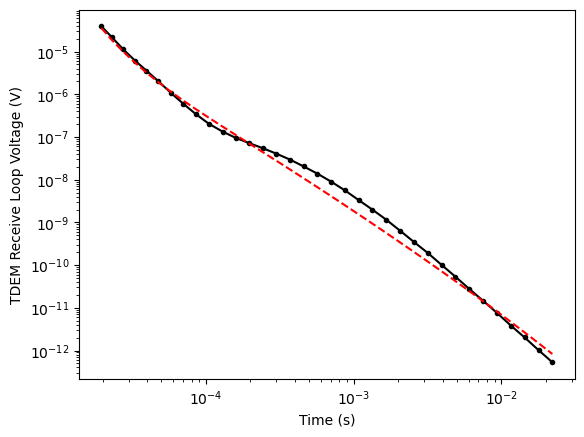

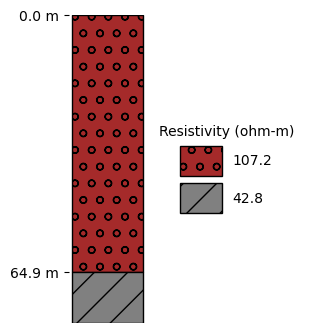

In [11]:
xinv = res.x
inv_layer_resistivities = xinv[:2]
inv_layer_thicknesses = xinv[2:]
inv = walktem.walktem(inv_layer_resistivities, np.cumsum(inv_layer_thicknesses), t_obs, waveform, loopsize)

# Make plot
plt.loglog(t_obs, synth, "k.-")
plt.loglog(t_obs, inv, "r--")
plt.xlabel("Time (s)")
plt.ylabel("TDEM Receive Loop Voltage (V)")

# Resistivity column
walktem.strat_plot(inv_layer_thicknesses.tolist(), inv_layer_resistivities.tolist(), hatches=["o", "/", "o"], colors=["brown", "grey", "brown"], labels=["300 ohm-m", "1 ohm-m"])

Great! We've recovered our known original model. Spend some time playing with this example. Change things like the initial guess, the misfit function, or the parameter bounds and see what happens. Can you find an earth model that has a good fit to the data, but is very different from the true model?

Now it is your turn to invert real data.

# Part 2 - Real data

We provide you with a code snippet below that loads a TDEM data file acquired on Sit' Tlein. **Invert for a two-layer earth model (ice above the subglacial material) and provide an estimate for the resistivity of the material below Sit' Tlein.** Note - your answer should be reasonable but there is not an exact value we are seeking, as your result will vary based on your initial model and optimizer parameters. Spend some time trying to manually find a starting model that is reasonably similar to the observed data - this will help the optimization routine converge on a model that fits well.

Hint - Some info to get them going with a starting model

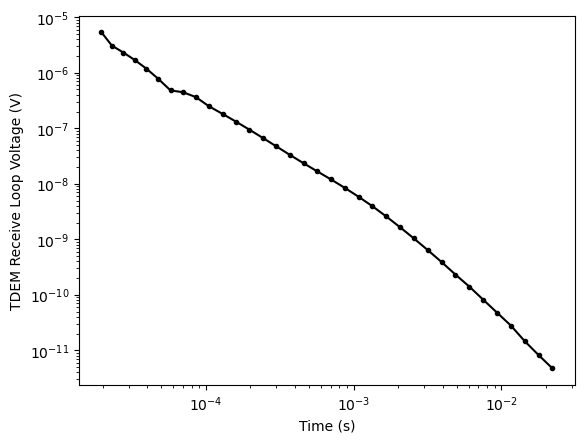

In [8]:
# Load TDEM data
data = pd.read_csv("./geo4_tdem.txt", header=1)
t_obs = data["t"].to_numpy()
v_obs = data["v"].to_numpy()

waveform = pd.read_csv("./tdem_waveform.txt", header=1)
waveform = {"t": waveform["t"].to_numpy(), "i": waveform["i"].to_numpy()}
loopsize = 40.0

# Plot
plt.loglog(t_obs, v_obs, "k.-")
plt.xlabel("Time (s)")
plt.ylabel("TDEM Receive Loop Voltage (V)")
plt.show()